<a href="https://colab.research.google.com/github/SamT2023/Flooding/blob/main/learning_modelling%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import the liibraries most suitable

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
data_P = pd.read_csv('/content/kabiyet.csv')
data_Q = pd.read_csv('/content/yala_Q.csv')

#assign datetime index
data_P['Date'] = pd.to_datetime(data_P['Date'], format="%d/%m/%Y %H:%M")
data_P = data_P.set_index('Date')

data_Q['Date'] = pd.to_datetime(data_Q['Date'], format="%d/%m/%Y %H:%M")
data_Q = data_Q.set_index('Date')

#Resample data_Q to daily mean values
data_Q_daily = data_Q[['WL (cm)','Q']].resample('D').mean()

#merge data_P and data_Q to create data_ML for training the model
#This merges the data by date
data_ML = pd.merge(data_P, data_Q_daily, how='inner', left_index=True, right_index=True)

#select data for the longest period available without missing values
data_ML = data_ML['1981-08-08':'1994-06-30']


In [3]:
data_ML.head()

,chirps_P,WL (cm),Q
Date,,,
1981-08-08,22.269,132.000005,18.01
1981-08-09,0.000,133.000004,18.62
1981-08-10,3.390,130.999994,17.42
1981-08-11,12.150,129.999995,16.84
1981-08-12,6.111,141.999996,24.87


In [4]:
#Resample the data to monthly and visualize
#I selected the longest period of data with the least missing values of Discharge
data_prec_monthly = data_ML['chirps_P'].resample('ME').sum()
#data_temp_monthly = data_ML['Temp']['1976-11-06':'1983-11-23'].resample('ME').mean()
data_dis_monthly = data_ML['WL (cm)'].resample('ME').mean()

Precipitation plotting

<ipython-input-7-b4cec24bac0b>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_prec_monthly = data_ML['chirps_P'].resample('M').sum()


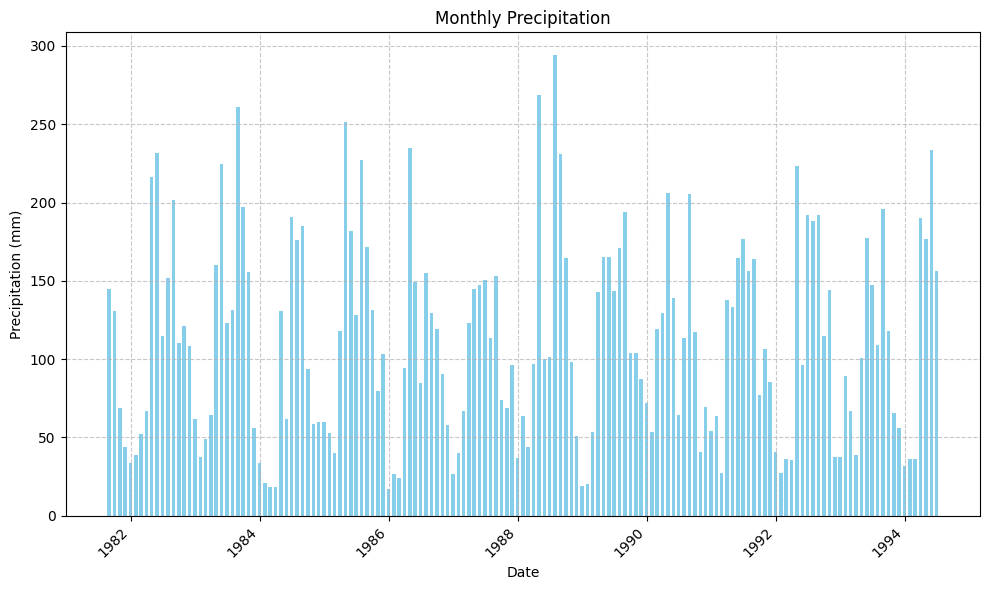

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Resample the data to monthly and sum precipitation for each month
# Use 'chirps_P' column instead of '/content/yala_P.csv'
data_prec_monthly = data_ML['chirps_P'].resample('M').sum()

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(data_prec_monthly.index, data_prec_monthly, color='skyblue', width=20)
plt.title('Monthly Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

<ipython-input-8-6cb15a90899b>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_dis_monthly = data_ML['Q'].resample('M').mean() # Resample to monthly mean discharge


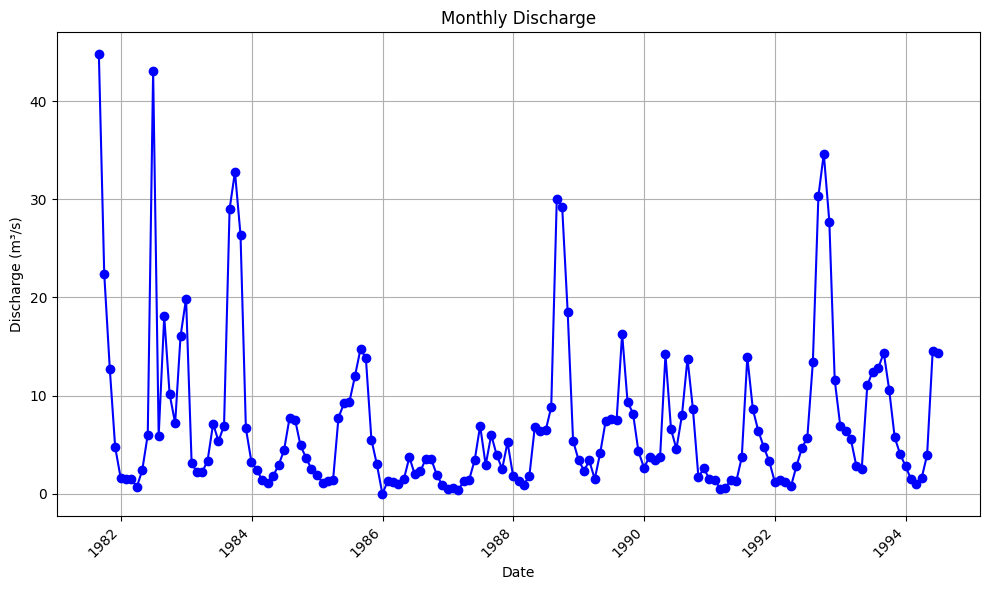

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming data_ML is your DataFrame and 'Q' represents discharge:
data_dis_monthly = data_ML['Q'].resample('M').mean() # Resample to monthly mean discharge

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(data_dis_monthly.index, data_dis_monthly, color='blue', marker='o') # Line plot with markers
plt.title('Monthly Discharge')
plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)') # Adjust units if needed
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

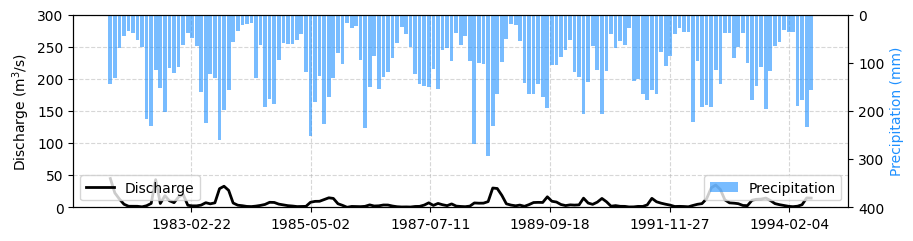

In [10]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 2.5))

# Create second y-axis (for precipitation)
ax2 = ax.twinx()

# Plot Discharge (Line Plot) on primary y-axis
ax.plot(data_dis_monthly.index, data_dis_monthly, color='black', label='Discharge', linewidth=2)

# Plot Precipitation (Bar Plot) on secondary y-axis
ax2.bar(data_prec_monthly.index, data_prec_monthly, color='dodgerblue', label='Precipitation', alpha=0.6, width=25)

# Invert y-axis for precipitation
ax2.invert_yaxis()

# Set y-axis labels and colors
ax.set_ylabel("Discharge (m$^3$/s)", color='black')
ax2.set_ylabel("Precipitation (mm)", color='dodgerblue')

# Set y-axis limits
ax.set_ylim(0, 300)  # Adjust limits as needed
ax2.set_ylim(400, 0) # Adjust limits as needed

# Set x-axis interval labels
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

# Align grid to discharge axis
ax.grid(True, linestyle='--', alpha=0.5)

# Legends
ax.legend(loc='lower left')
ax2.legend(loc='lower right')

# Show plot
plt.show()

In [25]:
!pip install plotly

In [26]:
import plotly.graph_objects as go
import numpy as np

# ... (your previous code to calculate pre_mon and q_mon) ...

# Create interactive plot with Plotly
fig = go.Figure()

# Add bar trace for precipitation
fig.add_trace(go.Bar(
    x=pre_mon.index,
    y=pre_mon.values,
    name='Precipitation',
    marker_color='dodgerblue',
    opacity=0.6,
    width=0.4  # Adjust bar width
))

# Add line trace for discharge
fig.add_trace(go.Scatter(
    x=q_mon.index,
    y=q_mon.values,
    name='Discharge',
    mode='lines+markers',
    marker_color='black',
    line=dict(color='black')
))

# Find peak discharge values and their indices
peak_indices = np.where(q_mon.values == q_mon.values.max())[0]
peak_values = q_mon.values[peak_indices]
peak_months = q_mon.index[peak_indices]

# Add annotations for peak discharge
for i, month in enumerate(peak_months):
    fig.add_annotation(
        x=month,
        y=peak_values[i],
        text=f"Peak: {peak_values[i]:.2f}",
        showarrow=True,
        arrowhead=1,
        ax=20,
        ay=-30
    )

# Update layout for better visualization
fig.update_layout(
    title="Monthly Precipitation and Discharge",
    xaxis_title="Month",
    yaxis_title="Precipitation (mm)",
    yaxis2=dict(
        title="Discharge (m³/s)",
        overlaying='y',
        side='right'
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=np.arange(1, 13),
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ),
    bargap=0.2,  # Adjust bar gap
    bargroupgap=0.1  # Adjust bar group gap
)

# Show plot
fig.show()

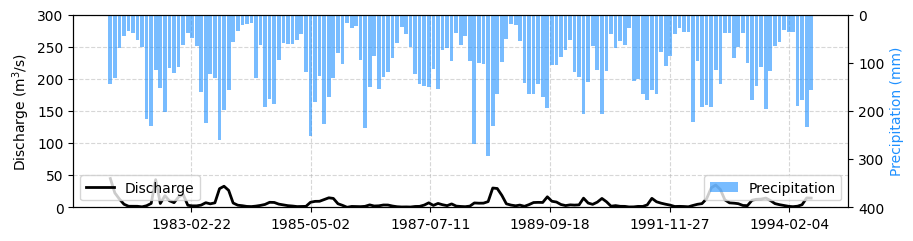

In [11]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 2.5))
# Create second y-axis (for precipitation)
ax2 = ax.twinx()
# Plot Discharge (Line Plot) on primary y-axis
ax.plot(data_dis_monthly.index, data_dis_monthly, color='black', label='Discharge', linewidth=2)
# Plot Precipitation (Bar Plot) on secondary y-axis
ax2.bar(data_prec_monthly.index, data_prec_monthly, color='dodgerblue', label='Precipitation', alpha=0.6, width=25)

# Invert y-axis for precipitation
ax2.invert_yaxis()
ax.set_ylabel("Discharge (m$^3$/s)", color='black')
ax2.set_ylabel("Precipitation (mm)", color='dodgerblue')
ax.set_ylim(0, 300)
ax2.set_ylim(400, 0)

# Set x-axis interval labels
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
# Align grid to discharge axis
ax.grid(True, linestyle='--', alpha=0.5)

# Legends
ax.legend(loc='lower left')
ax2.legend(loc='lower right')

# Show plot
plt.show()

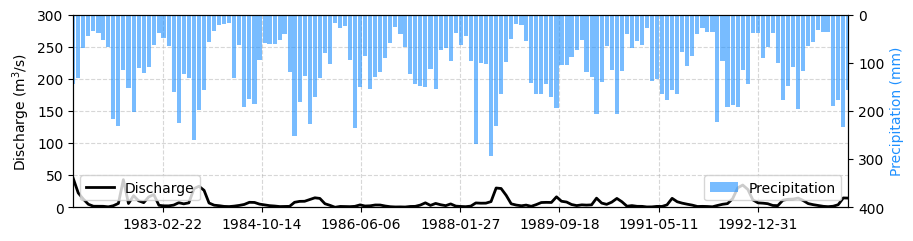

In [12]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 2.5))
# Create second y-axis (for precipitation)
ax2 = ax.twinx()
# Plot Discharge (Line Plot) on primary y-axis
ax.plot(data_dis_monthly.index, data_dis_monthly, color='black', label='Discharge', linewidth=2)
# Plot Precipitation (Bar Plot) on secondary y-axis
ax2.bar(data_prec_monthly.index, data_prec_monthly, color='dodgerblue', label='Precipitation', alpha=0.6, width=25)

# Invert y-axis for precipitation
ax2.invert_yaxis()
ax.set_ylabel("Discharge (m$^3$/s)", color='black')
ax2.set_ylabel("Precipitation (mm)", color='dodgerblue')
ax.set_ylim(0, 300)
ax2.set_ylim(400, 0)

# Set x-axis limits to start from the beginning
ax.set_xlim(data_dis_monthly.index.min(), data_dis_monthly.index.max())

# Set x-axis interval labels
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
# Align grid to discharge axis
ax.grid(True, linestyle='--', alpha=0.5)

# Legends
ax.legend(loc='lower left')
ax2.legend(loc='lower right')

# Show plot
plt.show()

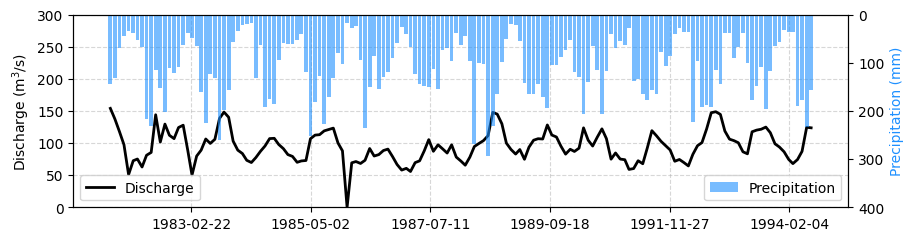

In [5]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 2.5))
# Create second y-axis (for precipitation)
ax2 = ax.twinx()
# Plot Discharge (Line Plot) on primary y-axis
ax.plot(data_dis_monthly.index, data_dis_monthly, color='black', label='Discharge', linewidth=2)
# Plot Precipitation (Bar Plot) on secondary y-axis
ax2.bar(data_prec_monthly.index, data_prec_monthly, color='dodgerblue', label='Precipitation', alpha=0.6, width=25)

# Invert y-axis for precipitation
ax2.invert_yaxis()
ax.set_ylabel("Discharge (m$^3$/s)", color='black')
ax2.set_ylabel("Precipitation (mm)", color='dodgerblue')
ax.set_ylim(0, 300)
ax2.set_ylim(400, 0)

# Set x-axis interval labels
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
# Align grid to discharge axis
ax.grid(True, linestyle='--', alpha=0.5)

# Legends
ax.legend(loc='lower left')
ax2.legend(loc='lower right')

# Show plot
plt.show()

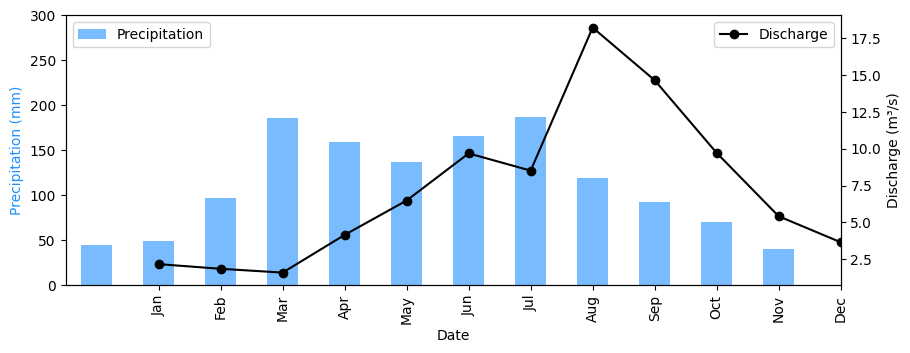

In [13]:
### Group data by month and visualize
pre_mon = data_prec_monthly.groupby(data_prec_monthly.index.month).mean()
q_mon = data_dis_monthly.groupby(data_dis_monthly.index.month).mean()
#t_mon = data_temp_monthly.groupby(data_temp_monthly.index.month).mean()

#Plot
fig, ax = plt.subplots(figsize=(10, 3.5))
pre_mon.plot(color='dodgerblue', label='Precipitation', kind='bar', alpha=0.6)
ax.set_ylim(0, 300)
ax.set_ylabel("Precipitation (mm)", color='dodgerblue')
ax2 = ax.twinx()
ax2.plot(q_mon.index, q_mon, color='black', label='Discharge', marker='o')
ax2.set_ylabel("Discharge (m³/s)", color='black')
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

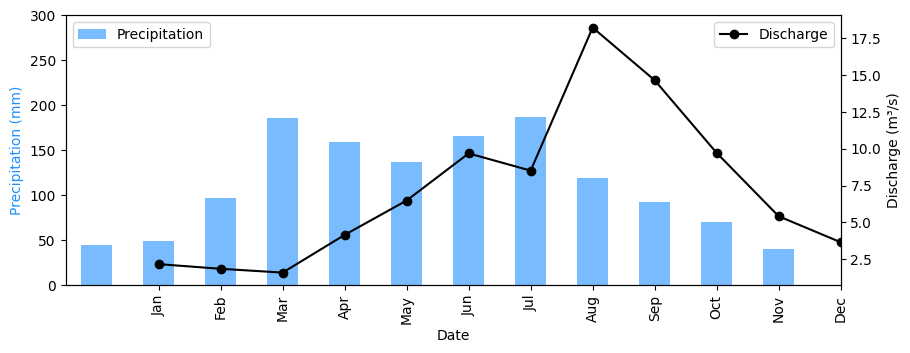

In [14]:
### Group data by month and visualize
pre_mon = data_prec_monthly.groupby(data_prec_monthly.index.month).mean()
q_mon = data_dis_monthly.groupby(data_dis_monthly.index.month).mean()
#t_mon = data_temp_monthly.groupby(data_temp_monthly.index.month).mean()

#Plot
fig, ax = plt.subplots(figsize=(10, 3.5))
pre_mon.plot(color='dodgerblue', label='Precipitation', kind='bar', alpha=0.6)
ax.set_ylim(0, 300)
ax.set_ylabel("Precipitation (mm)", color='dodgerblue')
ax2 = ax.twinx()
ax2.plot(q_mon.index, q_mon, color='black', label='Discharge', marker='o')
ax2.set_ylabel("Discharge (m³/s)", color='black')
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

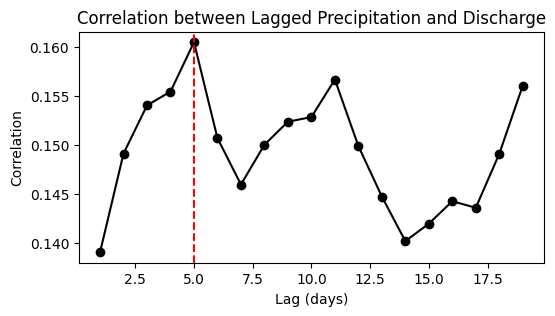

The maximum correlation (0.16) is at lag: 5 days.


In [15]:
# Define lags and initialize correlation list
lags = list(range(1, 20))  # Testing lags from 1 to 20 days
corr = []

# Compute correlation at different lags
for lag in lags:
    data_ML['Q_lag'] = data_ML['Q'].shift(-lag)  # Shift discharge Q forward by lag days
    # The lag is interpreted as: the value of P today affects Q after `lag` days
    lagged_data = data_ML[['chirps_P', 'Q_lag', 'WL (cm)']].dropna()  # Drop NaN rows
    corr.append(lagged_data.corr().iloc[0, 1])  # Compute correlation between chirps_P and Q_lag

# Convert results to a DataFrame
correlation_results = pd.DataFrame({"Lag (days)": lags, "Correlation": corr})


#============Plot the correlation values================

# Plot correlation values
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(lags, corr, marker='o', color='black', linestyle='-')

# Set axis labels and title
ax.set_xlabel("Lag (days)")
ax.set_ylabel("Correlation")
ax.set_title("Correlation between Lagged Precipitation and Discharge")
plt.axvline(x=lags[np.argmax(corr)], color='red', linestyle='--', label='Max Correlation')
# Display plot
plt.show()

# Find the lag with the maximum correlation
best_lag = lags[np.argmax(corr)]
max_corr = max(corr)
print(f"The maximum correlation ({max_corr:.2f}) is at lag: {best_lag} days.")

# Shift discharge Q forward by the best lag
data_ML['Q_lag'] = data_ML['Q'].shift(-best_lag)
data_ML = data_ML.dropna()  # Drop NaN rows

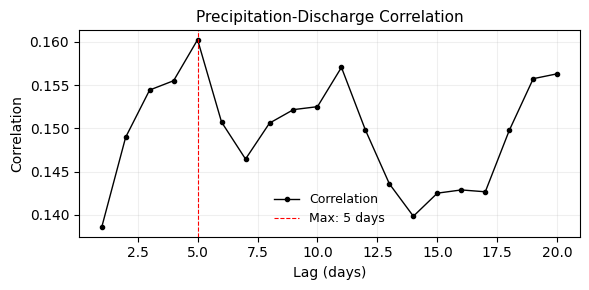

✅ Max correlation (0.16) at lag: 5 days.


<ipython-input-17-5745d59e18c5>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ML["Q_lag"] = data_ML["Q"].shift(-best_lag)
<ipython-input-17-5745d59e18c5>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ML.dropna(inplace=True)


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define lags and compute correlation
lags = np.arange(1, 21)
correlations = [
    data_ML.assign(Q_lag=data_ML["Q"].shift(-lag))
    .dropna()[["chirps_P", "Q_lag"]]
    .corr().iloc[0, 1]
    for lag in lags
]

# Find best lag
best_lag = lags[np.argmax(correlations)]
max_corr = max(correlations)

# Plot correlation values
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(lags, correlations, marker='o', linestyle='-', color='black', linewidth=1, markersize=3, label="Correlation")
ax.axvline(best_lag, color='red', linestyle='--', linewidth=0.8, label=f'Max: {best_lag} days')

# Formatting
ax.set_xlabel("Lag (days)", fontsize=10)
ax.set_ylabel("Correlation", fontsize=10)
ax.set_title("Precipitation-Discharge Correlation", fontsize=11)
ax.grid(alpha=0.2)
ax.legend(frameon=False, fontsize=9)

plt.tight_layout()
plt.show()

# Print the best lag
print(f"✅ Max correlation ({max_corr:.2f}) at lag: {best_lag} days.")

# Apply the best lag to shift discharge
data_ML["Q_lag"] = data_ML["Q"].shift(-best_lag)
data_ML.dropna(inplace=True)


#### Define Features and Labels
In machine learning the predictor variables (input variables) while the output variable you are trying to predict is called a label. In this case precipitation and temperatures are the features and discharge is the label
The inputs are normally represented by an X (in caps) and the label by a y
This is a simple definition but you get the flow

In [18]:
"""
This process is to impute missing values in the data
It is important to note that the imputation process should be done before splitting the data into training and testing sets
Depending on the power of your computer, you can choose to use the IterativeImputer or the SimpleImputer
It is an iterative that can take a long time to run if you have a large dataset and many iterations (max_iter)
"""
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100),
    initial_strategy='mean',
    max_iter=10,
    random_state=42,
    verbose=2
)

# Fit and transform missing data
imputed_data = imputer.fit_transform(data_ML)

# Convert back to DataFrame
data_imputed = pd.DataFrame(imputed_data, columns=data_ML.columns, index=data_ML.index)

[IterativeImputer] Completing matrix with shape (4700, 4)
[IterativeImputer] Ending imputation round 1/10, elapsed time 6.44
[IterativeImputer] Change: 0.0, scaled tolerance: 0.25972500000000004 
[IterativeImputer] Early stopping criterion reached.


#### Split the data into training and testing sets
You need to split the data into a training set that you use to train your model to make predictions and then set aside a training set to verify how the model performs for data it has not seen.  
READ MORE ABOUT THIS!!!!

In [19]:
# Add lagged discharge features for the past 1 to 5 days
for lag in range(1, 6):  # Add lags from 1 to 5 days
    data_imputed[f'Q_lag{lag}'] = data_imputed['Q'].shift(lag)

# Drop NaN values caused by shifting
data_imputed = data_imputed.dropna()

In [20]:
# First, organize your data into features and target
# Assuming your data is in a DataFrame called 'df'

# Define Features (X) and Target (y)
X = data_imputed[['chirps_P', 'Q_lag1', 'Q_lag2', 'Q_lag3', 'Q_lag4','Q_lag5']]  #precipitation and discharge from the past 5 days
y = data_imputed['Q']  # Target is current discharge

In [21]:
#Create time series split object
#tscv is a generator that yields the indices of the training and test sets
#n_splits=5 means the data is split into 5 folds for cross-validation.This means that the data is split into 5 training and testing sets
#Instead of the original data being split randomly, the data is split in a time series order so that the model does not use future data (precipitation and temp) to predict past data
"""STRONGLY RECOMMENDED TO USE TIME SERIES SPLIT FOR TIME SERIES DATA"""
"""ALSO STRONGLLY TO READ THE DOCUMENTATION OF TIME SERIES SPLIT TO UNDERSTAND HOW IT WORKS"""

tscv = TimeSeriesSplit(n_splits=5)

# Split the data while preserving time order
#y_test is the observed discharge values that the model is trying to predict
#y_pred is the predicted discharge values by the model
#X_train, X_test are the training and testing features

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

## Apply Random Forest as your choice of ML to predict discharge
Let's get to the exciting and complicated stuff
For this case, I use RF to make predictions of discharge.  

### Please read about how Random Forest works and the underlying Decision Trees behind it.
Depending on the configuration, running a ML can take a looong time

Understand what the parameters of RF model is
Also understand the performance statistics used for the RF model

In [22]:
"""-----------------------------------Random Forest Regressor---------------------------------------------"""
#Define the parameters of the RF model
# Time Series Split (5 Folds)
#This means that the data is split into 5 training and testing sets
tscv = TimeSeriesSplit(n_splits=5)

# Define RF Parameter Grid
param_dist = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [10, 20, 30],  # Tree depth
    'min_samples_split': [5, 10],  # Minimum samples for split
    'min_samples_leaf': [2],  # Minimum samples in leaf
    'max_features': ['sqrt', 'log2', None]  # Feature selection strategy
}

# Apply Grid Search with Time Series Cross-Validation
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_dist,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

# Split Data for Training (80%) & Testing (20%)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:] #split the feature data into training and testing sets
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:] #split the label data into training and testing sets

# Train RF with Best Parameters
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best Parameters Found: {best_params}")

# Perform Time Series Cross-Validation with Best RF Model
results = []  # Store performance metrics


# Perform Time Series Cross-Validation with Best RF Model
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Fit the best model on each fold
    best_model.fit(X_train_fold, y_train_fold)

    # Make predictions
    y_pred_fold = best_model.predict(X_test_fold)

    # Compute Performance Metrics
    mse = mean_squared_error(y_test_fold, y_pred_fold)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_fold, y_pred_fold)
    nse = 1 - (np.sum((y_test_fold - y_pred_fold)**2) / np.sum((y_test_fold - np.mean(y_test_fold))**2))

    # Store results
    results.append([i + 1, mse, rmse, r2, nse])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Fold', 'MSE', 'RMSE', 'R²', 'NSE'])

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters Found: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


#### Model Performance statistics

In [23]:
results_df

,Fold,MSE,RMSE,R²,NSE
0,1,6.640766,2.576968,0.854533,0.854533
1,2,0.419361,0.647581,0.916488,0.916488
2,3,8.650176,2.941118,0.883417,0.883417
3,4,1.068573,1.033718,0.959111,0.959111
4,5,12.109742,3.479905,0.885028,0.885028


### Plotting the results

As you can see from the performance statistics the model performs very well. The performance stats all indicate very good values

Let's now plot the discharge that has been predicted by the RF model and test how they compare with the subset of the data we set aside as a test set

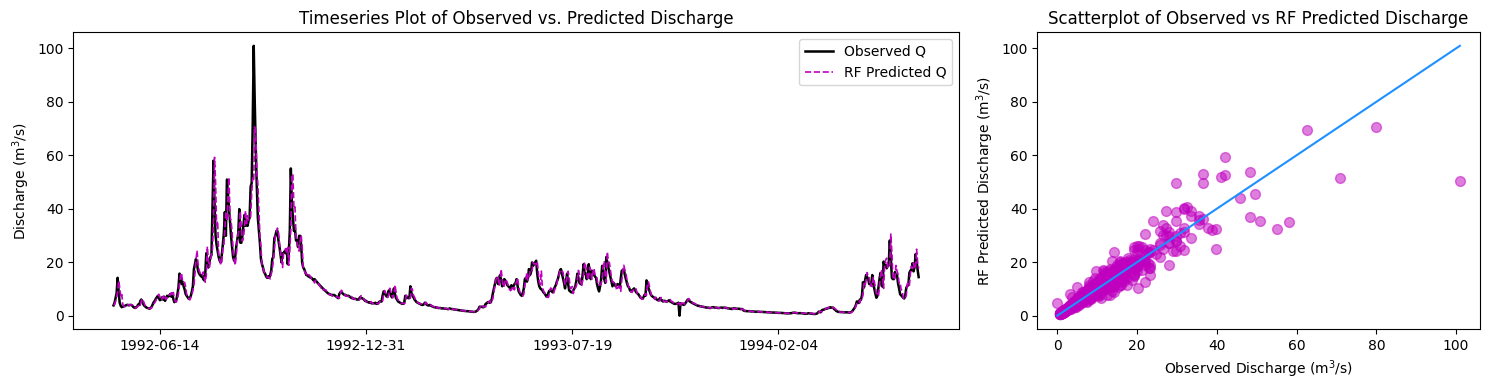

In [24]:
#plot the model predictions
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create figure and define grid layout
fig = plt.figure(figsize=(15, 4))  # Adjust figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2:1 aspect ratio

# Create subplots with different widths
ax0 = fig.add_subplot(gs[0])  # First subplot (line plot) - Twice as wide
ax1 = fig.add_subplot(gs[1])  # Second subplot (scatter plot) - Half width

ax0.plot(y_test_fold.index, y_test_fold, color='k', label='Observed Q', lw=1.8)
ax0.plot(y_test_fold.index, y_pred_fold, color='m', label='RF Predicted Q', lw=1.2, linestyle='--')
ax0.set_ylabel("Discharge (m$^3$/s)")
ax0.xaxis.set_major_locator(plt.MaxNLocator(5))  # Set x-axis ticks
ax0.legend()
ax0.set_title("Timeseries Plot of Observed vs. Predicted Discharge")


ax1.scatter(y_test_fold, y_pred_fold, color='m', alpha=0.5, s=50)
ax1.set_xlabel("Observed Discharge (m$^3$/s)")
ax1.set_ylabel("RF Predicted Discharge (m$^3$/s)")

# 1:1 reference line (ideal predictions)
min_val = min(min(y_test_fold), min(y_pred_fold))
max_val = max(max(y_test_fold), max(y_pred_fold))
ax1.plot([min_val, max_val], [min_val, max_val], color='dodgerblue')

ax1.set_title("Scatterplot of Observed vs RF Predicted Discharge")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
